# Company Violation Regression 

The goal of this project is to determine which companies are taking their violations seriously and which ones are not. This could be useful for consumers in understanding which companies they might want to support. This could also be useful for the government in understanding which companies are likely to commit further violations. 

## Setup

In [ ]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, Normalizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

In [ ]:
parents = pd.read_csv('parents_cleaned.csv').drop('Unnamed: 0', axis=1)
violations = pd.read_csv('violations_cleaned.csv').drop('Unnamed: 0', axis=1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Parents Data

In [ ]:
parents.head()

,parent_name,pen_total,num_recs,rank,ownership,hq_country,hq_state,industry,major_industry
0,1-800-Flowers.com,44681,5,3044,publicly traded,USA,new york,retail-internet flowers,retailing
1,1366 Technologies,25720,2,3120,privately held,USA,massachusetts,electronic equipment,electrical and electronic equipment
2,1st Financial Bank USA,10183142,3,1162,privately held,USA,south dakota,banking,financial services
3,21st Century Oncology,82750000,4,494,privately held,USA,florida,healthcare services,healthcare services
4,220 Laboratories Inc.,130300,5,2801,privately held,USA,california,hair and skin products,household and personal care products


In [ ]:
parents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3415 entries, 0 to 3414
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   parent_name     3415 non-null   object
 1   pen_total       3415 non-null   int64 
 2   num_recs        3415 non-null   int64 
 3   rank            3415 non-null   int64 
 4   ownership       3415 non-null   object
 5   hq_country      3415 non-null   object
 6   hq_state        2608 non-null   object
 7   industry        3415 non-null   object
 8   major_industry  3415 non-null   object
dtypes: int64(3), object(6)
memory usage: 240.2+ KB


In [ ]:
parents.describe()

,pen_total,num_recs,rank
count,3.415000e+03,3415.000000,3415.000000
mean,1.982965e+08,30.587408,1664.376867
std,2.000247e+09,129.966024,946.154110
min,5.000000e+03,1.000000,1.000000
25%,3.896490e+05,3.000000,848.500000
50%,2.745817e+06,8.000000,1680.000000
75%,2.315530e+07,23.000000,2472.500000
max,8.289678e+10,3869.000000,3268.000000


## Violations Data

In [ ]:
violations.head()

,agency,agency_code,pen_year,company,city,state,zip,parent_name,penalty,sub_penalty,penalty_adjusted,civil_criminal,offense_group,primary_offense,secondary_offense,naics_tr,govt_level,case_category
0,Labor Department Wage and Hour Division,WHD,2006,38 Corp.,new york,new york,10014,NaN,42925,0,42925,civil,employment-related offenses,wage and hour violation,fair labor standards act,full-service restaurants,federal,agency action
1,Labor Department Wage and Hour Division,WHD,2008,75 Inc.,hailey,idaho,83333,NaN,7215,0,7215,civil,employment-related offenses,wage and hour violation,fair labor standards act,full-service restaurants,federal,agency action
2,Labor Department Wage and Hour Division,WHD,2005,"123, Inc.",fort wayne,indiana,46804,NaN,42864,0,42864,civil,employment-related offenses,wage and hour violation,fair labor standards act,full-service restaurants,federal,agency action
3,Labor Department Wage and Hour Division,WHD,2011,180 Company LLC,west hazleton,pennsylvania,18202,NaN,10757,0,10757,civil,employment-related offenses,wage and hour violation,fair labor standards act,automotive parts and accessories stores,federal,agency action
4,Labor Department Wage and Hour Division,WHD,2011,242 Incorporated,cambridge,massachusetts,2238,NaN,42493,0,42493,civil,employment-related offenses,wage and hour violation,fair labor standards act,full-service restaurants,federal,agency action


In [ ]:
violations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496559 entries, 0 to 496558
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   agency             494033 non-null  object
 1   agency_code        494033 non-null  object
 2   pen_year           496559 non-null  int64 
 3   company            496559 non-null  object
 4   city               371352 non-null  object
 5   state              450199 non-null  object
 6   zip                291999 non-null  object
 7   parent_name        104456 non-null  object
 8   penalty            496559 non-null  int64 
 9   sub_penalty        496559 non-null  int64 
 10  penalty_adjusted   496559 non-null  int64 
 11  civil_criminal     496559 non-null  object
 12  offense_group      496559 non-null  object
 13  primary_offense    496559 non-null  object
 14  secondary_offense  112014 non-null  object
 15  naics_tr           263998 non-null  object
 16  govt_level         4

In [ ]:
violations.describe()

,pen_year,penalty,sub_penalty,penalty_adjusted
count,496559.000000,4.965590e+05,4.965590e+05,4.965590e+05
mean,2011.785143,1.572915e+06,1.135481e+05,1.459367e+06
std,5.524707,7.768990e+07,1.398750e+07,7.639918e+07
min,2000.000000,5.000000e+03,0.000000e+00,0.000000e+00
25%,2008.000000,6.825000e+03,0.000000e+00,6.800000e+03
50%,2012.000000,1.040300e+04,0.000000e+00,1.032900e+04
75%,2016.000000,2.303950e+04,0.000000e+00,2.280000e+04
max,2021.000000,2.080000e+10,4.900000e+09,2.080000e+10


In [ ]:
# Format the company field. Not perfect but good enough.
violations_transform_1 = violations.copy()
violations_transform_1.company = violations_transform_1.company.str.upper()
violations_transform_1.company = violations_transform_1.company.str.replace('.', '')
violations_transform_1.company = violations_transform_1.company.str.replace(',', '')
violations_transform_1.company = violations_transform_1.company.str.replace('COMPANY', '')
violations_transform_1.company = violations_transform_1.company.str.replace('CORPERATION', '')
violations_transform_1.company = violations_transform_1.company.str.replace('CORP', '')
violations_transform_1.company = violations_transform_1.company.str.replace('INCORPERATED', '')
violations_transform_1.company = violations_transform_1.company.str.replace(' CO', '')
violations_transform_1.company = violations_transform_1.company.str.replace('INC', '')
violations_transform_1.company = violations_transform_1.company.str.replace('LLC', '')
violations_transform_1.company = violations_transform_1.company.apply(lambda company : company.strip())

In [ ]:
violation_count_by_company = violations_transform_1.company.value_counts()
violation_count_by_company

UNION PACIFIC RAILROAD                             3377
BNSF RAILWAY                                       2217
CSX TRANSPORTATION                                 1646
NORFOLK SOUTHERN RAILWAY                           1321
PEABODY MIDWEST MINING                              635
                                                   ... 
A-1 MASTER ROOFING                                    1
AMMED DIRECT                                          1
SHOP 'N' SAVE WAREHOUSE FOODS                         1
GEORGE QUINONES DBA PROFESSIONALNSTRUCTION SERV       1
CAMERON GENERALNTRACTORS                              1
Name: company, Length: 323577, dtype: int64

In [ ]:
# Only get violations for companies with >= 20 total violations
m = violations_transform_1.apply(lambda row : violation_count_by_company[row['company']] >= 20, axis=1)
violations_transform_2 = violations_transform_1[m]
violations_transform_2

,agency,agency_code,pen_year,company,city,state,zip,parent_name,penalty,sub_penalty,penalty_adjusted,civil_criminal,offense_group,primary_offense,secondary_offense,naics_tr,govt_level,case_category
479,National Labor Relations Board,NLRB,2005,3M,st. paul,minnesota,55104,3M Company,60000,0,60000,civil,employment-related offenses,labor relations violation,NaN,coated and laminated paper manufacturing,federal,agency action
480,National Labor Relations Board,NLRB,2008,3M,maplewood,minnesota,55144,3M Company,22839,0,22839,civil,employment-related offenses,labor relations violation,NaN,stationery and office supplies merchant wholes...,federal,agency action
481,Federal Railroad Administration,FRA,2003,3M,NaN,NaN,NaN,3M Company,15000,0,15000,civil,safety-related offenses,railroad safety violation,NaN,NaN,federal,agency action
482,Federal Railroad Administration,FRA,2003,3M,NaN,NaN,NaN,3M Company,5000,0,5000,civil,safety-related offenses,railroad safety violation,NaN,NaN,federal,agency action
483,Equal Employment Opportunity Commission,EEOC,2011,3M,NaN,NaN,NaN,3M Company,3000000,0,3000000,civil,employment-related offenses,employment discrimination,NaN,NaN,federal,agency action
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496547,NaN,NaN,2003,EXXON MOBIL,NaN,california,NaN,Exxon Mobil,30800000,0,30800000,civil,environment-related offenses,environmental violation,NaN,NaN,state,private litigation
496551,NaN,NaN,2003,SOLUTIA,NaN,alabama,NaN,Eastman Chemical,50000000,0,50000000,civil,environment-related offenses,environmental violation,NaN,NaN,federal,private litigation
496552,NaN,NaN,2002,SHELL OIL,NaN,california,NaN,Royal Dutch Shell,28000000,0,28000000,civil,environment-related offenses,environmental violation,NaN,NaN,federal,private litigation
496553,NaN,NaN,2002,LYONDELL CHEMICAL,NaN,california,NaN,LyondellBasell Industries,4000000,0,4000000,civil,environment-related offenses,environmental violation,NaN,NaN,state,private litigation


In [ ]:
# Get total penalty amount for each company by year
violations_by_company_year = violations_transform_2.groupby(['company', 'pen_year']).sum()
violations_by_company_year = violations_by_company_year.reset_index()
violations_by_company_year = violations_by_company_year.drop(['sub_penalty', 'penalty_adjusted'], axis=1)
violations_by_company_year

,company,pen_year,penalty
0,3M,2000,5000
1,3M,2001,5900
2,3M,2002,6000
3,3M,2003,98395
4,3M,2004,59225
...,...,...,...
9184,ZURICH AMERICAN INSURANCE,2015,210200
9185,ZURICH AMERICAN INSURANCE,2016,70012
9186,ZURICH AMERICAN INSURANCE,2017,40900
9187,ZURICH AMERICAN INSURANCE,2018,42000


In [ ]:
# Create extra rows for missing years. (If company is missing year y, it means
# there was no violation/pentalty for year y)
temp_dataframes = []
companies = violations_by_company_year.company.unique()

for company in companies:
  temp = violations_by_company_year[violations_by_company_year.company==company]
  temp=temp.set_index('pen_year')
  temp=temp.reindex(np.arange(2000, 2021), fill_value=0)
  temp.company = company
  temp=temp.reset_index()

  temp_dataframes.append(temp)

violations_by_company_year_transform_1 = pd.concat(temp_dataframes, ignore_index=True)
violations_by_company_year_transform_1

,pen_year,company,penalty
0,2000,3M,5000
1,2001,3M,5900
2,2002,3M,6000
3,2003,3M,98395
4,2004,3M,59225
...,...,...,...
16690,2016,ZURICH AMERICAN INSURANCE,70012
16691,2017,ZURICH AMERICAN INSURANCE,40900
16692,2018,ZURICH AMERICAN INSURANCE,42000
16693,2019,ZURICH AMERICAN INSURANCE,15000


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


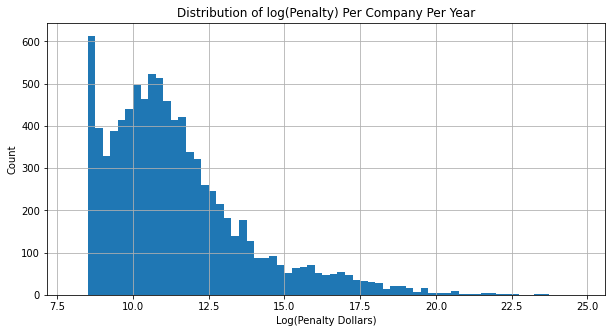

Note: This plot does not show count of $0 penalty.


In [ ]:
plt.title("Distribution of log(Penalty) Per Company Per Year")
plt.xlabel("Log(Penalty Dollars)")
plt.ylabel("Count")
np.log(violations_by_company_year_transform_1['penalty']) \
  .hist(bins = np.arange(8,25, 0.25), figsize = (10, 5))
plt.show();
print('Note: This plot does not show count of $0 penalty.')

## Feature Engineering 

(basic features on whole data set)

In [ ]:
violations_feat = violations_by_company_year_transform_1.copy()

In [ ]:
# For Reference
violations_transform_2.head(3)

,agency,agency_code,pen_year,company,city,state,zip,parent_name,penalty,sub_penalty,penalty_adjusted,civil_criminal,offense_group,primary_offense,secondary_offense,naics_tr,govt_level,case_category
479,National Labor Relations Board,NLRB,2005,3M,st. paul,minnesota,55104,3M Company,60000,0,60000,civil,employment-related offenses,labor relations violation,NaN,coated and laminated paper manufacturing,federal,agency action
480,National Labor Relations Board,NLRB,2008,3M,maplewood,minnesota,55144,3M Company,22839,0,22839,civil,employment-related offenses,labor relations violation,NaN,stationery and office supplies merchant wholes...,federal,agency action
481,Federal Railroad Administration,FRA,2003,3M,NaN,NaN,NaN,3M Company,15000,0,15000,civil,safety-related offenses,railroad safety violation,NaN,NaN,federal,agency action


In [ ]:
def get_cat_target_percent(violations_transform_2_cat_feat, target):
  """
  Gets the % of target in violations_transform_2_cat_feat for each 
  company in each year. Returns new violations_feat with merged data.

  Params:
  violations_transform_2_cat_feat: 
    A categorical feature in the dataframe violations_transform_2.
  target:
    The category you want to find the % of for each company year
  """
  df = violations_transform_2[['company', 'pen_year', violations_transform_2_cat_feat]]
  df[violations_transform_2_cat_feat] = (df[violations_transform_2_cat_feat] == target)*1.0
  df = df.groupby(['company', 'pen_year']).mean()
  df = df.reset_index()

  return violations_feat.merge(
    df, 
    on=['pen_year', 'company'], 
    how='left'
  ).fillna(-1).rename({violations_transform_2_cat_feat:target}, axis=1)

In [ ]:
# Get % of cases that are 'agency action' for each company each year
violations_feat = get_cat_target_percent('offense_group', 'safety-related offenses')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [ ]:
violations_feat = get_cat_target_percent('govt_level', 'federal')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [ ]:
violations_feat_final = violations_feat
violations_feat_final

,pen_year,company,penalty,safety-related offenses,federal
0,2000,3M,5000,1.000000,1.0
1,2001,3M,5900,0.000000,0.0
2,2002,3M,6000,1.000000,1.0
3,2003,3M,98395,0.666667,1.0
4,2004,3M,59225,1.000000,1.0
...,...,...,...,...,...
16690,2016,ZURICH AMERICAN INSURANCE,70012,0.000000,0.0
16691,2017,ZURICH AMERICAN INSURANCE,40900,0.000000,0.0
16692,2018,ZURICH AMERICAN INSURANCE,42000,0.000000,0.0
16693,2019,ZURICH AMERICAN INSURANCE,15000,0.000000,0.0


## Final Preprocessing Steps

### Split Data into Train/Test

In [ ]:
# Train set contains years 2000 to 2014 (inclusive)
train = violations_feat_final[violations_feat_final.pen_year <= 2014]

# Test set contains years 2015 to 2020 (inclusive)
test = violations_feat_final[violations_feat_final.pen_year >= 2015]

print(train, '\n', test)

       pen_year                    company  ...  safety-related offenses  federal
0          2000                         3M  ...                 1.000000      1.0
1          2001                         3M  ...                 0.000000      0.0
2          2002                         3M  ...                 1.000000      1.0
3          2003                         3M  ...                 0.666667      1.0
4          2004                         3M  ...                 1.000000      1.0
...         ...                        ...  ...                      ...      ...
16684      2010  ZURICH AMERICAN INSURANCE  ...                 0.000000      0.0
16685      2011  ZURICH AMERICAN INSURANCE  ...                 0.000000      0.0
16686      2012  ZURICH AMERICAN INSURANCE  ...                 0.000000      0.0
16687      2013  ZURICH AMERICAN INSURANCE  ...                 0.000000      0.0
16688      2014  ZURICH AMERICAN INSURANCE  ...                 0.000000      0.0

[11925 rows x 5

### Transform Data for Time Series

In [ ]:
# year1, year2, year3, year4, year5 extra features, output (year6)
# [5000, 5900, 6000, ...] -> [98395]
# [5900, 6000, 98395, ...] -> [59225]


def format_for_time_series(df_orig, company):
  """
  Params:
    df: DataFrame with columns pen_year, company, and penalty
  Return:
    DataFrame with columns company, year1_penalty, year2_penalty, year3_penalty,  
    year4_penalty, year5_penalty, and target_penalty (year 6)
  """
  df = df_orig[df_orig['company'] == company]

  # Features
  company_ = df.company[:-5].reset_index().company

  year1_penalty = df.penalty[:-5].reset_index().penalty
  year2_penalty = df.penalty[1:-4].reset_index().penalty
  year3_penalty = df.penalty[2:-3].reset_index().penalty
  year4_penalty = df.penalty[3:-2].reset_index().penalty
  year5_penalty = df.penalty[4:-1].reset_index().penalty
  year1_year5_avg_rate_of_change = (year5_penalty - year1_penalty) / 4

  year1_federal = df.federal[:-5].reset_index().federal
  year2_federal = df.federal[1:-4].reset_index().federal
  year3_federal = df.federal[2:-3].reset_index().federal
  year4_federal = df.federal[3:-2].reset_index().federal
  year5_federal = df.federal[4:-1].reset_index().federal

  year1_safety_offenses = df['safety-related offenses'][:-5].reset_index()['safety-related offenses']
  year2_safety_offenses = df['safety-related offenses'][1:-4].reset_index()['safety-related offenses']
  year3_safety_offenses = df['safety-related offenses'][2:-3].reset_index()['safety-related offenses']
  year4_safety_offenses = df['safety-related offenses'][3:-2].reset_index()['safety-related offenses']
  year5_safety_offenses = df['safety-related offenses'][4:-1].reset_index()['safety-related offenses']

  max_penalty_category = np.ones(len(company_))*0.001
  if any(df.penalty > 1000000):
    max_penalty_category = np.ones(len(company_))*0.010
  if any(df.penalty > 10000000):
    max_penalty_category = np.ones(len(company_))*0.100
  if any(df.penalty > 100000000):
    max_penalty_category = np.ones(len(company_))*1.000

  # Target
  target_penalty = df.penalty[5:].reset_index().penalty


  return pd.DataFrame({
      'company':company_,
      'year1_penalty':year1_penalty, 
      'year2_penalty':year2_penalty, 
      'year3_penalty':year3_penalty,
      'year4_penalty':year4_penalty,
      'year5_penalty':year5_penalty,
      'year1_federal':year1_federal,
      'year2_federal':year2_federal,
      'year3_federal':year3_federal,
      'year4_federal':year4_federal,
      'year5_federal':year5_federal,
      'year1_safety_offenses':year1_safety_offenses, 
      'year2_safety_offenses':year2_safety_offenses, 
      'year3_safety_offenses':year3_safety_offenses,
      'year4_safety_offenses':year4_safety_offenses,
      'year5_safety_offenses':year5_safety_offenses, 
      'year1_year5_avg_rate_of_change':year1_year5_avg_rate_of_change, 
      'max_penalty_category':max_penalty_category,
      'target_penalty':target_penalty
  })

In [ ]:
# Concat all the dfs together
temp_dataframes_train = []
temp_dataframes_test = []
companies = violations_feat.company.unique()

for company in companies:
  temp_dataframes_train.append(format_for_time_series(train, company))
  temp_dataframes_test.append(format_for_time_series(test, company))

train_formatted = pd.concat(temp_dataframes_train, ignore_index=True)
test_formatted = pd.concat(temp_dataframes_test, ignore_index=True)

In [ ]:
train_formatted.sample(10, random_state=2)

,company,year1_penalty,year2_penalty,year3_penalty,year4_penalty,year5_penalty,year1_federal,year2_federal,year3_federal,year4_federal,year5_federal,year1_safety_offenses,year2_safety_offenses,year3_safety_offenses,year4_safety_offenses,year5_safety_offenses,year1_year5_avg_rate_of_change,max_penalty_category,target_penalty
1109,BRISTOL-MYERS SQUIBB,4428154,27600000,20000,0,0,1.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,-1.000000,-1.000000,-1107038.5,1.000,0
4844,MINGO LOGANAL,0,0,5300,43000,0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.000000,-1.000000,0.0,0.001,17844
5072,NATIONAL CEMENT OF CALIFORNIA,0,0,0,30000,0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.000000,-1.000000,0.0,0.001,40560
1205,CALIFORNIA PHYSICIANS' SERVICE DBA BLUE SHIELD...,105000,130000,570000,1360000,57500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,-11875.0,0.010,745000
4906,MONTANA RAIL LINK,22750,0,30000,40000,26470,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.000000,1.000000,930.0,0.001,0
7416,UNIVAR USA,7400,19480,10250,40380,62000,0.0,1.0,0.5,1.0,1.0,0.0,0.5,0.5,0.333333,0.666667,13650.0,0.001,206250
5060,NALLY & HAMILTON ENTERPRISES,5060,0,101475,0,34300,1.0,-1.0,0.0,-1.0,0.0,1.0,-1.0,0.0,-1.000000,0.000000,7310.0,0.001,6400
4622,MASSACHUSETTS BAY TRANSPORTATION AUTHORITY,0,0,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,0.0,0.001,12750
584,ARJNSTRUCTION,0,12600,0,0,42800,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.000000,1.000000,10700.0,0.001,17738
6141,ROSEBUD MINING,0,15000,15000,0,125000,-1.0,0.0,0.0,-1.0,1.0,-1.0,0.0,0.0,-1.000000,1.000000,31250.0,0.001,90450


### Split into Feature Matrix and Target Vector

In [ ]:
X_train, y_train = train_formatted.drop('target_penalty',axis=1), train_formatted.target_penalty
X_test, y_test = test_formatted.drop('target_penalty',axis=1), test_formatted.target_penalty

### Modification on Only Training Data (X_train, y_train)

In [ ]:
# y_train[(y_train > 10000000)] = 10000000

## Transformations for Categorical Data & Dim. Reduction

### One Hot Encoding

In [ ]:
# Encode categorical variables
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [ ]:
X_train_mpc = X_train.max_penalty_category
X_test_mpc = X_test.max_penalty_category

### Normalize Data

In [ ]:
# Normalize before dim reduction
norm = Normalizer()
X_train = norm.fit_transform(X_train)
X_test = norm.transform(X_test)

### Validation Set

In [ ]:
# Validation Split from Test Data
X_val = X_test[:len(X_test)//2]
y_val = y_test[:len(y_test)//2]

X_test_2 = X_test[len(X_test)//2:]
y_test_2 = y_test[len(y_test)//2:].reset_index().target_penalty

### Dimensionality Reduction

In [ ]:
# Reduce dimensionality
trunk = TruncatedSVD(n_components=20)
X_train = trunk.fit_transform(X_train)
X_val = trunk.transform(X_val)
X_test_2 = trunk.transform(X_test_2)

In [ ]:
X_train = pd.DataFrame(X_train)
X_train['max_penalty_category'] = X_train_mpc
X_val = pd.DataFrame(X_val)
X_val['max_penalty_category'] = X_test_mpc[:len(X_test)//2]
X_test_2 = pd.DataFrame(X_test_2)
X_test_2['max_penalty_category'] = X_test_mpc[len(X_test)//2:].reset_index().max_penalty_category

## Model Building

In [ ]:
def prototype_model(model):
  model = model.fit(X_train, y_train)

  # Training set prediction
  predictions_train = model.predict(X_train)
  residuals_train = y_train - predictions_train # residuals = actual - predicted
  hi_train = np.percentile(residuals_train, 95) # get the residual that is larger than 95% of the other residuals
  bottom_95_train = (residuals_train < hi_train) # [1,9,4,6,7] < 5 => [True, False, True, False, False]

  predictions_val = model.predict(X_val)
  residuals_val = y_val - predictions_val
  hi_val = np.percentile(residuals_val, 95)
  bottom_95_val = (residuals_val < hi_val)

  print(model,  
        '\nRMSE (Train Set):', mean_squared_error(y_train[bottom_95_train], predictions_train[bottom_95_train])**0.5, 
        '\nRMSE (Validation Set):', mean_squared_error(y_val[bottom_95_val], predictions_val[bottom_95_val])**0.5)
  return pd.DataFrame({'Actual':y_val, 'Predicted':predictions_val})

In [ ]:
linear_regression = LinearRegression()
lin_reg_val_results = prototype_model(linear_regression)
lin_reg_val_results

LinearRegression() 
RMSE (Train Set): 839653.4465187368 
RMSE (Validation Set): 760016.3657123552


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


,Actual,Predicted
0,5266,4.011155e+06
1,85436,4.250225e+05
2,0,3.834583e+05
3,63750,3.813720e+05
4,15000,7.558251e+05
...,...,...
392,0,3.605188e+05
393,0,5.359941e+04
394,172500,2.521875e+05
395,113000,3.276699e+05


In [ ]:
gradient_boosting_regressor = GradientBoostingRegressor(n_estimators = 25,
    max_depth=2, 
    random_state=0, 
    loss = 'absolute_error' # Good for predicting "typical violation fees"
)

gbc_absolute_val_results = prototype_model(gradient_boosting_regressor)
gbc_absolute_val_results

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


GradientBoostingRegressor(loss='absolute_error', max_depth=2, n_estimators=25,
                          random_state=0) 
RMSE (Train Set): 390906.34518483916 
RMSE (Validation Set): 208799.79295807722


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


,Actual,Predicted
0,5266,83248.083520
1,85436,48535.527978
2,0,45437.544599
3,63750,39193.101555
4,15000,55335.174514
...,...,...
392,0,28122.075229
393,0,1178.070598
394,172500,8199.085815
395,113000,28122.075229


In [ ]:
gradient_boosting_regressor_squared = GradientBoostingRegressor(n_estimators = 25,
    max_depth=2, 
    random_state=0, 
    loss = 'squared_error' # Better for predicting outliers
)

gbc_squared_val_results = prototype_model(gradient_boosting_regressor_squared)
gbc_squared_val_results

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


GradientBoostingRegressor(max_depth=2, n_estimators=25, random_state=0) 
RMSE (Train Set): 829801.2313574586 
RMSE (Validation Set): 734543.6662179561


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


,Actual,Predicted
0,5266,2.970641e+06
1,85436,5.173883e+05
2,0,1.274109e+05
3,63750,1.274109e+05
4,15000,1.817228e+06
...,...,...
392,0,1.274109e+05
393,0,9.714241e+04
394,172500,1.073655e+05
395,113000,1.274109e+05


In [ ]:
knn = KNeighborsRegressor()
knn_val_results = prototype_model(knn)
knn_val_results

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


KNeighborsRegressor() 
RMSE (Train Set): 896338.2906140223 
RMSE (Validation Set): 888682.8183809976


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


,Actual,Predicted
0,5266,6001600.0
1,85436,162984.8
2,0,92374.2
3,63750,40056.0
4,15000,27465.6
...,...,...
392,0,11402.8
393,0,69318.6
394,172500,9260.0
395,113000,650555.4


In [ ]:
random_forest = RandomForestRegressor( 
    n_estimators = 25,
    max_depth=2, 
    random_state=0, 
    n_jobs=-1
)
rfr_squared_val_results = prototype_model(random_forest)
rfr_squared_val_results

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


RandomForestRegressor(max_depth=2, n_estimators=25, n_jobs=-1, random_state=0) 
RMSE (Train Set): 899442.2013453804 
RMSE (Validation Set): 822051.3474378207


,Actual,Predicted
0,5266,3.635734e+06
1,85436,5.217233e+05
2,0,6.460591e+04
3,63750,6.460591e+04
4,15000,1.808382e+06
...,...,...
392,0,6.460591e+04
393,0,6.460591e+04
394,172500,6.460591e+04
395,113000,6.460591e+04


In [ ]:
random_forest_criterion = RandomForestRegressor( 
    n_estimators = 25,
    max_depth=2, 
    random_state=0, 
    n_jobs=-1, 
    criterion="absolute_error"
)
rfr_absolute_val_results = prototype_model(random_forest_criterion)
rfr_absolute_val_results

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


RandomForestRegressor(criterion='absolute_error', max_depth=2, n_estimators=25,
                      n_jobs=-1, random_state=0) 
RMSE (Train Set): 444628.1718362523 
RMSE (Validation Set): 241808.71993830623


,Actual,Predicted
0,5266,309472.28
1,85436,33513.06
2,0,33513.06
3,63750,33513.06
4,15000,33513.06
...,...,...
392,0,33513.06
393,0,0.00
394,172500,2721.28
395,113000,32591.78


### Stacking Regressor (The Actual Model)

In [ ]:
estimators = [
    #Format: ('name', model)
    ('linear_regression', linear_regression),
    ('random_forest', random_forest),
    ('random_forest_criterion', random_forest_criterion),
    ('k_nearest_neighbor', knn),
    ('gradient_boosting_regressor', gradient_boosting_regressor),
    ('gradient_boosting_regressor_squared',gradient_boosting_regressor_squared),
    # Add more models here
]

stacking_reg = StackingRegressor(
    estimators=estimators, 
    final_estimator=GradientBoostingRegressor(n_estimators = 25,
    max_depth=2, 
    random_state=0, 
    loss = 'huber'
    )
)

stacking_val_results = prototype_model(stacking_reg)
stacking_val_results

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

StackingRegressor(estimators=[('linear_regression', LinearRegression()),
                              ('random_forest',
                               RandomForestRegressor(max_depth=2,
                                                     n_estimators=25, n_jobs=-1,
                                                     random_state=0)),
                              ('random_forest_criterion',
                               RandomForestRegressor(criterion='absolute_error',
                                                     max_depth=2,
                                                     n_estimators=25, n_jobs=-1,
                                                     random_state=0)),
                              ('k_nearest_neighbor', KNeighborsRegressor()),
                              ('gradient_boosting_regressor',
                               GradientBoostingRegressor(loss='absolute_error',
                                                         max_depth=2,
               

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


,Actual,Predicted
0,5266,334806.201958
1,85436,220422.476670
2,0,88365.377235
3,63750,79611.596053
4,15000,258425.638089
...,...,...
392,0,79611.596053
393,0,28793.105343
394,172500,31757.216342
395,113000,74211.768902


## Test Set:

In [ ]:
# Test
predictions = stacking_reg.predict(X_test_2)

residuals = y_test_2 - predictions
hi = np.percentile(residuals, 95)
bottom_95 = (residuals < hi)

print('\nRMSE Test:', mean_squared_error(y_test_2[bottom_95], predictions[bottom_95])**0.5)
final_results = pd.DataFrame({'Actual':y_test_2.reset_index().target_penalty, 'Predicted':stacking_reg.predict(X_test_2)})
final_results

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea


RMSE Test: 210003.38960208613


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


,Actual,Predicted
0,6750,55065.459974
1,44603,88365.377235
2,0,49665.632823
3,498474,53958.162382
4,0,28793.105343
...,...,...
393,18811,28793.105343
394,201884,205960.223580
395,0,179926.236485
396,0,126464.542117




# Conclusion

The final RMSE on the test set was $210,003. In general the results weren't as good as I had hoped. Some things to try in the future are to potentially group or cluster companies and using and using that as a feature instead of one hot encoding company names. I think having other data like the size of the company, valuation, existing reputation, etc. would have gone a long way in improving the model. 

### Self Reflection

This was my first time working with time series data and I learned a lot about creating a time series model. At first, I wanted to use some type of LSTM neural network but I quickly discovered that the data did not fit with what I originally had in mind. This entire project stemmed from the dataset and I thought it would be a good opportunity to learn something new. Looking back, I think that the data was probably not suited for a time series model and the overall goal is probably a foolish one. Eventhough the project did not turn out as I had hoped, I'm still happy that I did it because I now know more about what's required for a time series project to be successful.